# Вратар

### Краток опис

Во оваа дигитална тетратка е прикажан примерот за роботот вратар од книгата Веројатностна роботика. Примерот служи за објаснување на основните концепти кај Баесовиот филтер.

In [1]:
import numpy as np
import plotly.offline as pl
import plotly.graph_objs as go

In [2]:
pl.init_notebook_mode(connected=True)

Веројатноста за премин од една во наредна состојба е дадена преку променливата `state_transition_p`

In [3]:
# key = (new_state, control_input, current_state)
state_transition_p = {('open', 'push', 'open'): 1,
                      ('closed', 'push', 'open'): 0,
                      ('open', 'push', 'closed'): 0.8,
                      ('closed', 'push', 'closed'): 0.2,
                      ('open', 'do_nothing', 'open'): 1,
                      ('closed', 'do_nothing', 'open'): 0,
                      ('open', 'do_nothing', 'closed'): 0,
                      ('closed', 'do_nothing', 'closed'): 1}

Веројатноста за измериме податок во зависност од состојбата во која се наоѓаме е дадена преку променливата  `measurement_p`

In [4]:
# key = (measurement, current_state)
measurement_p = {('open', 'open'): 0.6,
                 ('closed', 'open'): 0.4,
                 ('open', 'closed'): 0.2,
                 ('closed', 'closed'): 0.8}

Нашето првично верување е моделирано како рамномерна распределба преку променливата `belief`. Ова ни кажува дека немаме ни најмала информација дали вратата е отворена или затворена. 

In [5]:
states = ['open', 'closed']
belief = {'open': 0.5, 'closed': 0.5}
assert sum(belief.values()) == 1, 'Total belief not equal to 1'

In [6]:
def normalize_belief(belief):
    """
    Normalize the (dictionary based) belief distribution to represent probability
    """
    
    normalizer = sum(belief.values())
    for state in belief:
        belief[state] /= normalizer
    return belief

Ќе направиме симулација на работата на овој робот. За секоја временска единица можеме да кажеме кој да биде управувачкиот сигнал, а кое да биде мерењето. Врз таа основа ќе ја пресметаме веројатноста колку е вратата отворена. Резултатот е прикажан на графикот подолу.

In [7]:
belief_history = [belief['open']]
simulation_seconds = 100
simulation_time = range(simulation_seconds)
for _ in simulation_time:
    u = 'do_nothing'
    z = np.random.choice(states, p=[0.6, 0.4])
    for new_state in states:
        belief_after_control_input = 0
        for state in states:
            belief_after_control_input += state_transition_p[(new_state, u, state)] * belief[state]
        belief[new_state] = measurement_p[(z, new_state)] * belief_after_control_input
    belief = normalize_belief(belief)
    belief_history.append(belief['open'])

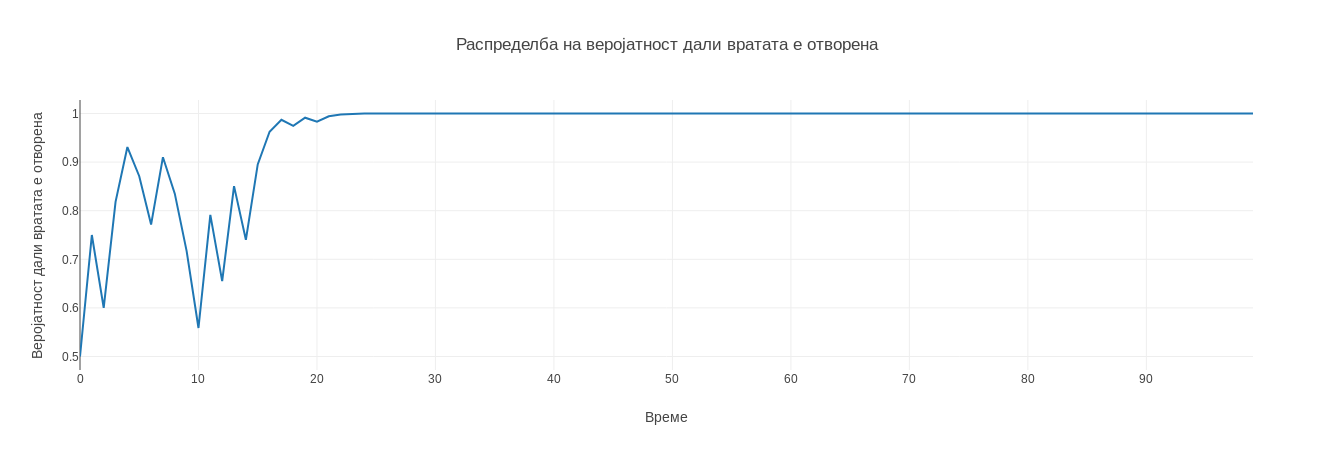

In [18]:
pl.iplot({'data': [go.Scatter(x=np.array(simulation_time), y=belief_history[:-1])],
          'layout': {'title': 'Распределба на веројатност дали вратата е отворена',
                     'xaxis': {'title': 'Време'},
                     'yaxis': {'title': 'Веројатност дали вратата е отворена'}}})

Иако ова претставување е интуитивно, не го претставува во најдобар облик она што го дава Баесовиот филтер на излез, а тоа е претставувањето на излезот како апроксимација на густината на веројатност на нашето верување. Се обидов да го направам како анимација, но не успеав да пронајдам како во plotly да ја исклучам интерполацијата помеѓу рамките во анимацијата, па малку сецка и не е визуелно привлечно. Сепак, останува на вас да го стекнете чувството како распределбата се менува со текот на време со што се подобрува нашето верување.

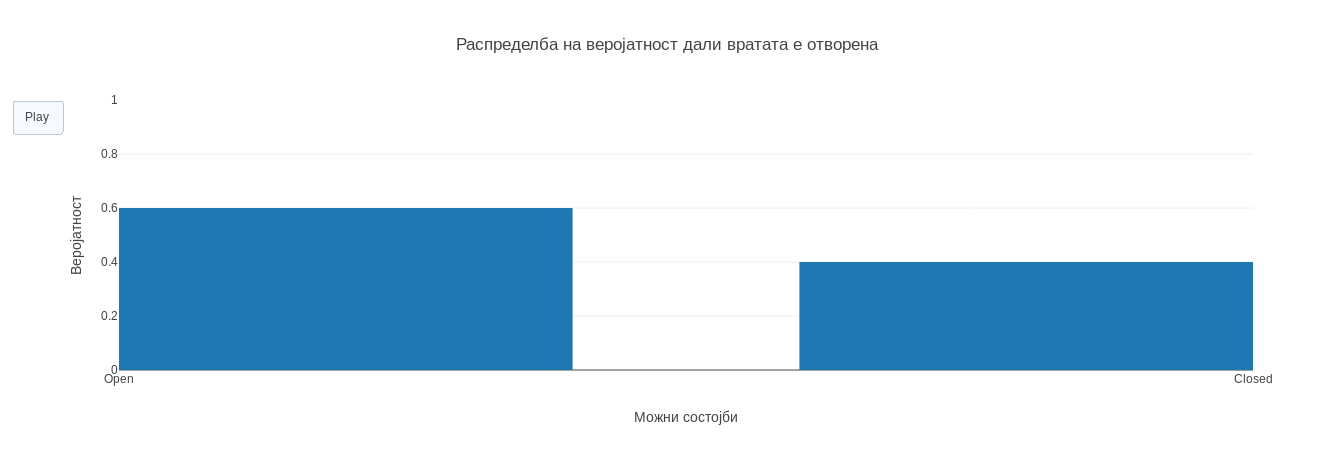

In [20]:
figure = {'data': [go.Bar(x=['Open', 'Closed'], y=[0.5, 0.5])],
          'layout': {'xaxis': {'range': [0, 1], 'autorange': False, 'title': 'Можни состојби'},
                     'yaxis': {'range': [0, 1], 'autorange': False, 'title': 'Веројатност'},
                     'title': 'Распределба на веројатност дали вратата е отворена',
                     'updatemenus': [{'type': 'buttons',
                                      'buttons': [{'label': 'Play',
                                                   'method': 'animate',
                                                   'args': [None]}]}]
                    },
          'frames': [{'data': [go.Bar(x=['Open', 'Closed'], y=[open_door_p, 1-open_door_p])]} 
                     for open_door_p in belief_history[:10]]
         }

pl.iplot(figure)